In [1]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys
%matplotlib inline

from functools import partial

## set parameters

In [2]:
learning_rate = 0.001

training_epochs = 20
batch_size = 256
display_step = 1

# Network Parameters
n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

examples_to_show = 5
# log directory for tensorboard
log_dir = '/tmp/tensorflow/autoencoder/logs/summaries'

## create wave form data
トレーニングと評価用に、一次元の波形データを作成します。  
波形は、幾つかの周波数成分を持つサイン波信号にガウス性雑音が加えられたものです。  


In [3]:
### Segment of Wave form : Angle, in radians (2 pi rad equals 360 degrees) 
train_min, train_max = 0, 10000
test_min, test_max = train_max, 12000

resolution = 0.1

### Common Wave form
def base_wave(t):
    return np.sin(t) / 3 + 0.5 * np.sin(t*5) + 0.25 * np.sin(t*10) 
    #return t * np.sin(t)  

### Train wave
def train_time_series(t):
    if t.ndim == 1:
        noise = np.random.rand(len(t))
    elif t.ndim == 2:
        noise = np.random.rand(t.shape[0], t.shape[1])
    else:
        noise = np.random.rand(t.shape[0], t.shape[1], t.shape[2])
    return base_wave(t) + 0.1 * noise

### get a "n_input" length wave randomly
def train_next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (train_max - train_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = train_time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, n_inputs), ys[:, 1:].reshape(-1, n_steps, n_inputs)


### Anomaly wave for Test wave
anomaly_start = 0.25    # Test wave全体長のおいて、anomaly_start(%)の位置から徐々にanomaly waveが出現
def test_time_series_anomary(t):
    norm = (t - test_min) / (test_max - test_min)
    norm = norm - anomaly_start
    norm = (norm > 0.0) * norm
    return np.sin(t * 20) *  (np.exp(norm) - 1) 


### Test wave
def test_time_series(t):
    if t.ndim == 1:
        noise = np.random.rand(len(t))
    elif t.ndim == 2:
        noise = np.random.rand(t.shape[0], t.shape[1])
    else:
        noise = np.random.rand(t.shape[0], t.shape[1], t.shape[2])
    return base_wave(t) + 0.1 * noise + test_time_series_anomary(t)

### get a "n_input" length wave randomly
def test_next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (test_max - test_min - n_steps * resolution)
    Ts = test_min + t0 + np.arange(0., n_steps + 1) * resolution
    ys = test_time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, n_inputs), ys[:, 1:].reshape(-1, n_steps, n_inputs)

## plot train data

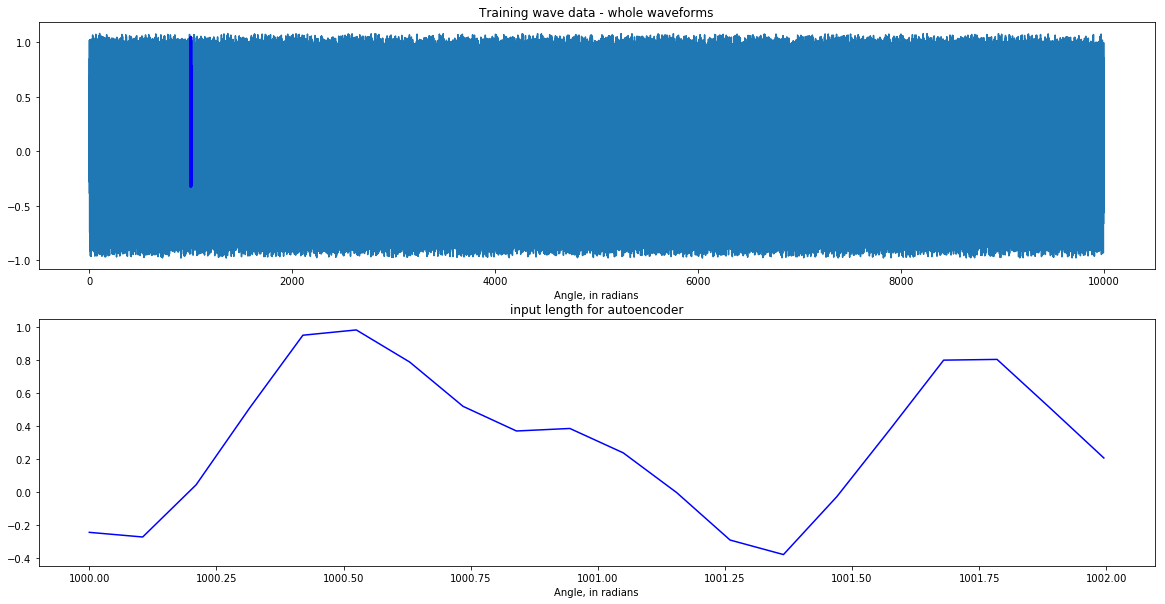

In [4]:
plot_point = 1000   # train_min <= plot_point <= train_max
t = np.linspace(train_min, train_max, int((train_max - train_min) / resolution))
t_instance = np.linspace(plot_point, plot_point + resolution * (n_steps + 1), n_steps + 1)
wave_size = len(t)

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(t, train_time_series(t), label=r"whole waveforms")
plt.plot(t_instance[:-1], train_time_series(t_instance[:-1]), "b-", linewidth=3, label="input length")
plt.title('Training wave data - whole waveforms')
plt.xlabel('Angle, in radians')
plt.subplot(212)
plt.plot(t_instance[:-1], train_time_series(t_instance[:-1]), "b-", label=r"input length")
plt.title('input length for autoencoder')
plt.xlabel('Angle, in radians')

## plot test data

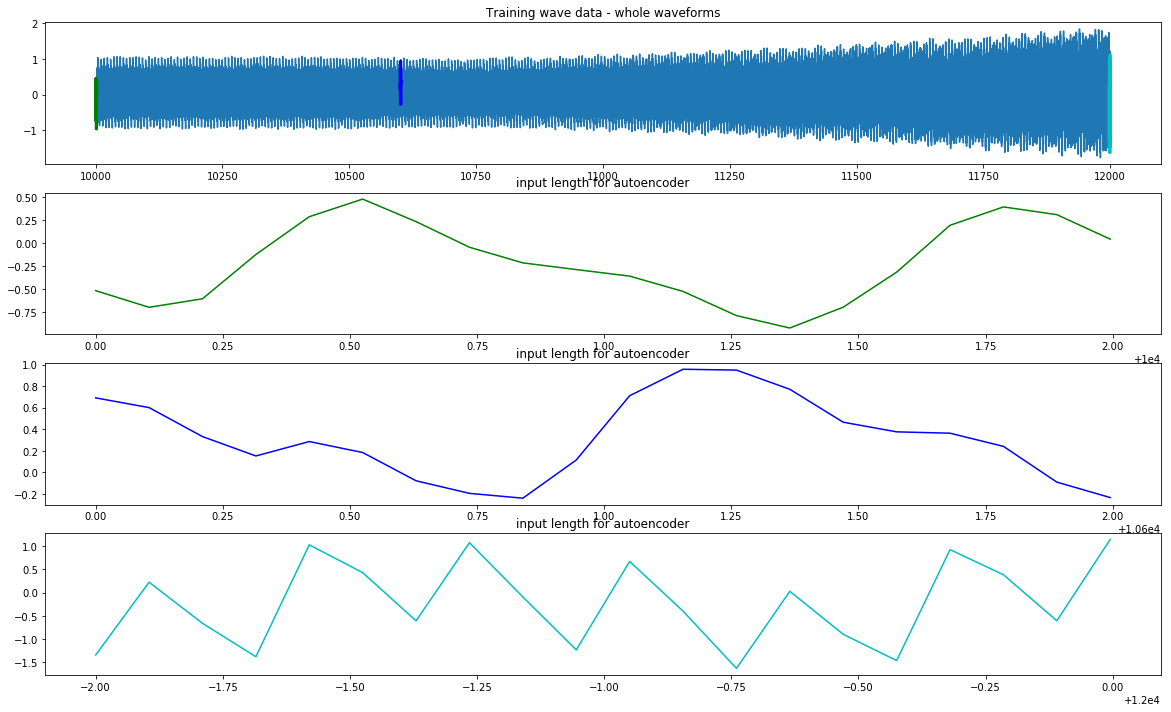

In [5]:
plot_point1 = test_min             # test_min <= plot_point <= test_max
plot_point2 = test_min + 600      # test_min <= plot_point <= test_max
plot_point3 = test_max - n_steps * resolution   # test_min <= plot_point <= test_max

t = np.linspace(test_min, test_max, int((test_max - test_min) / resolution))
t_instance1 = np.linspace(plot_point1, plot_point1 + resolution * (n_steps + 1), n_steps + 1)
t_instance2 = np.linspace(plot_point2, plot_point2 + resolution * (n_steps + 1), n_steps + 1)
t_instance3 = np.linspace(plot_point3, plot_point3 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(20,12))
plt.subplot(411)
plt.plot(t, test_time_series(t), label=r"whole wave")
plt.plot(t_instance1[:-1], test_time_series(t_instance1[:-1]), "g-", linewidth=3)
plt.plot(t_instance2[:-1], test_time_series(t_instance2[:-1]), "b-", linewidth=3)
plt.plot(t_instance3[:-1], test_time_series(t_instance3[:-1]), "c-", linewidth=3)
plt.title('Training wave data - whole waveforms')
#plt.xlabel('Angle, in radians')
plt.subplot(412)
plt.plot(t_instance1[:-1], test_time_series(t_instance1[:-1]), "g-")
plt.title('input length for autoencoder')
#plt.xlabel('Angle, in radians')
plt.subplot(413)
plt.plot(t_instance2[:-1], test_time_series(t_instance2[:-1]), "b-")
plt.title('input length for autoencoder')
#plt.xlabel('Angle, in radians')
plt.subplot(414)
plt.plot(t_instance3[:-1], test_time_series(t_instance3[:-1]), "c-")
plt.title('input length for autoencoder')
#plt.xlabel('Angle, in radians')

In [6]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
reset_graph()    

### Store values for  tensorbord 

In [7]:
def variable_summaries(var):
    """ Attach a lot of summaries to a Tensor (for TensorBoard visualization). """
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

## Placehoder for Input

In [8]:
with tf.variable_scope('input'):
    X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
    
with tf.variable_scope('output'):
    y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

## 標準layer関数を作成

ここでは、重みの初期化に"He"を、regularizerに"l2"を設定する。  
また、tensorboardへの表示用の出力も設定する。

In [9]:
"""
def rnn_layer(n_neurons, name, activation=tf.nn.relu):
    with tf.variable_scope(name):
        
        cell = tf.contrib.rnn.OutputProjectionWrapper(
            tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=activation), 
            output_size=n_outputs)
        
        layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, name)
        with tf.variable_scope('weights'):
            variable_summaries(layer_vars[0])
        with tf.variable_scope('biases'):
            variable_summaries(layer_vars[1])
        with tf.variable_scope('activation'):
            tf.summary.histogram('activations', cell)
        return cell
"""

"\ndef rnn_layer(n_neurons, name, activation=tf.nn.relu):\n    with tf.variable_scope(name):\n        \n        cell = tf.contrib.rnn.OutputProjectionWrapper(\n            tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=activation), \n            output_size=n_outputs)\n        \n        layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, name)\n        with tf.variable_scope('weights'):\n            variable_summaries(layer_vars[0])\n        with tf.variable_scope('biases'):\n            variable_summaries(layer_vars[1])\n        with tf.variable_scope('activation'):\n            tf.summary.histogram('activations', cell)\n        return cell\n"

## ロス値計算部 - 二乗和誤差

In [10]:

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu),
    output_size=n_outputs)

# Prediction
with tf.name_scope('prediction'):
    y_pred, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

# Targets (Labels) are the input data.
with tf.name_scope('target'):
    y = y
    

# Define loss and optimizer, minimize the squared error
with tf.name_scope('reduce_mean'):
    cost = tf.reduce_mean(tf.square(y_pred - y)) # MSE
tf.summary.scalar('reduce_mean', cost)


with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training & Evaluation

Epoch: 0001 cost= 0.010464543
Epoch: 0002 cost= 0.008187024
Epoch: 0003 cost= 0.007654310
Epoch: 0004 cost= 0.007320802
Epoch: 0005 cost= 0.006680000
Epoch: 0006 cost= 0.006499501
Epoch: 0007 cost= 0.006634007
Epoch: 0008 cost= 0.006672167
Epoch: 0009 cost= 0.006466889
Epoch: 0010 cost= 0.006590914
Epoch: 0011 cost= 0.006840654
Epoch: 0012 cost= 0.005785356
Epoch: 0013 cost= 0.005993992
Epoch: 0014 cost= 0.005910170
Epoch: 0015 cost= 0.006206186
Epoch: 0016 cost= 0.005924368
Epoch: 0017 cost= 0.006184595
Epoch: 0018 cost= 0.005706305
Epoch: 0019 cost= 0.005982893
Epoch: 0020 cost= 0.006096927
Optimization Finished!


/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


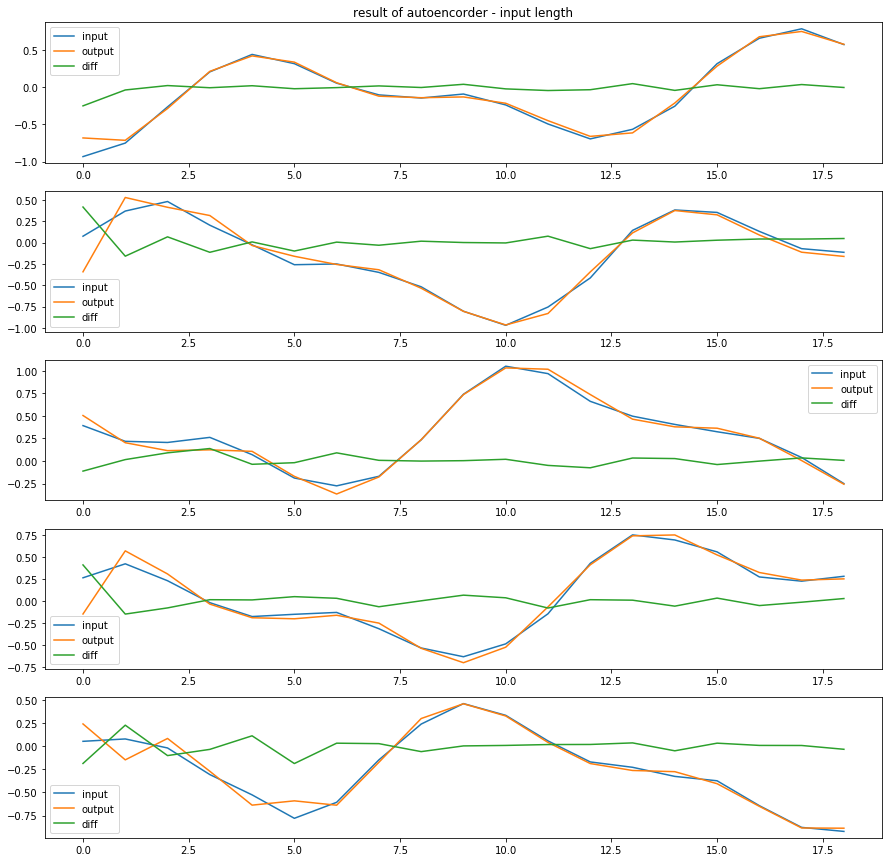

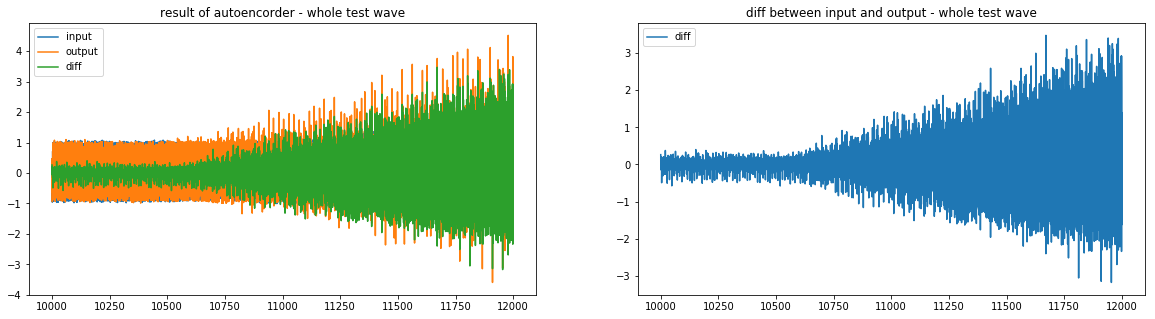

In [11]:
# Initializing the variables
merged = tf.summary.merge_all()
init = tf.global_variables_initializer()

if tf.gfile.Exists(log_dir):
    tf.gfile.DeleteRecursively(log_dir)
tf.gfile.MakeDirs(log_dir)

saver = tf.train.Saver()
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(log_dir + '/test')

    total_batch = int(wave_size/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = train_next_batch(batch_size, n_steps)
            # Run optimization op (backprop) adn cost op (to get loss value)
            summary, _, c = sess.run([merged, optimizer, cost], feed_dict={X: batch_xs, y: batch_ys})
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
            sys.stdout.flush()
        train_writer.add_summary(summary, epoch)
    print("Optimization Finished!")
    train_writer.close()
    test_writer.close()
    saver.save(sess, "./my_model")

    # Plot wave form : result of autoencorder - input length
    batch_xs, batch_ys = train_next_batch(examples_to_show, n_steps)
    train_encode_decode = sess.run(y_pred,
                             feed_dict={X: batch_xs})
    # Compare original images with their reconstructions
    f, a = plt.subplots(examples_to_show, 1, figsize=(15, 15))
    for i in range(examples_to_show):
        a[i].plot(batch_xs[i][1:], label='input')
        a[i].plot(train_encode_decode[i][:-1], label='output')
        a[i].plot(batch_xs[i][1:] - train_encode_decode[i][:-1], label='diff')
        a[i].legend()
        a[0].set_title('result of autoencorder - input length')
    f.show()
    
    # Plot wave form : result of autoencorder - whole test wave
    t = np.linspace(test_min, test_max, int((test_max - test_min) / resolution))
    n_data = int(len(t) / n_steps) * n_steps
    x_batch = t[:n_data].reshape(-1, n_steps, 1)
    test_encode_decode = sess.run(y_pred,
                             feed_dict={X: test_time_series(x_batch)})
    
    f, a = plt.subplots(1, 2, figsize=(20, 5))
    input_wave = test_time_series(x_batch.reshape(-1,1))
    output_wave = test_encode_decode.reshape(-1,1)
    a[0].plot(t[1:n_data], input_wave[1:], label='input')
    a[0].plot(t[1:n_data], output_wave[:-1], label='output')
    a[0].plot(t[1:n_data], output_wave[:-1] - input_wave[1:], label='diff')
    a[0].legend()
    a[0].set_title('result of autoencorder - whole test wave')
    a[1].plot(t[1:n_data], output_wave[:-1] - input_wave[1:], label='diff')
    a[1].legend()
    a[1].set_title('diff between input and output - whole test wave')
    

sess.close()

## Generating waves

In [12]:
with tf.Session() as sess:                        # not shown in the book
    saver.restore(sess, "./my_model") # not shown

    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        outputs = sess.run(y_pred, feed_dict={X: X_batch})
        sequence.append(outputs[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_model


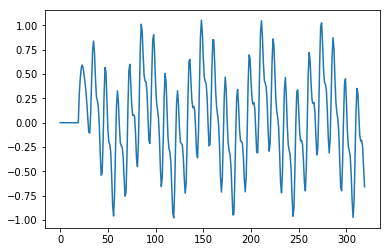

In [13]:
plt.plot(sequence)